In [204]:
import torch
from transformers import AutoTokenizer, PretrainedConfig
from peft import PeftModel, LoraConfig, TaskType, get_peft_model, PeftConfig
from datasets import DatasetDict, Dataset
import os
import numpy as np
import pandas as pd
import json
import seqeval
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
test_file = "Thesis/dataset_sentence_ sample_(new_split)/test.jsonl"
test_data = []

with open(test_file, 'r') as f:
    for line in f:
        test_data.append(json.loads(line))

2171

In [72]:
predictions = "Thesis/dataset_sentence_ sample_(new_split)/output_test_new_split.jsonl"
prediction_data = []
tokenizer_path = "Thesis/checkpoint-9200"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
with open(predictions, 'r') as f:
    for line in f:
        prediction_data.append(json.loads(line))

In [73]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [74]:
# convert the test data into datastructure that is acceptable by the tokenization and aligning function
converted_data = {
    "tokens": [item["tokens"] for item in test_data],
    "ner_tags": [item["ner_tags"] for item in test_data]
}
inputs_sentences = tokenize_and_align_labels(converted_data)

In [75]:
def compute_metrics(p):
    seqeval = evaluate.load("seqeval")
    predictions, labels = p
    label_list = list(label2id.keys())
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    print(len(true_predictions))
    print(f"this is the true_pred:{true_predictions}")
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    print(f"this is the true_labels:{true_labels}")
    print(len(true_labels))
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [77]:
predictions = [item['predictions'] for item in prediction_data]
labels = inputs_sentences['labels']
results_test = compute_metrics((predictions,labels))

2171
this is the true_pred:[['O'], ['O', 'O', 'O', 'O', 'O'], ['Arg2-as-denier', 'Synchronous', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Synchronous', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Arg2-as-manner', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Conjunction', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

/Users/mahmoudelsayed/opt/anaconda3/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Arg2-as-denier seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/mahmoudelsayed/opt/anaconda3/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Arg1-as-denier seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/mahmoudelsayed/opt/anaconda3/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Synchronous seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/mahmoudelsayed/opt/anaconda3/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Arg1-as-goal seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/mahmoudelsayed/opt/anaconda3/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Conjunction se

## Combining tokens with labels for test data for better visualization and comparison

In [144]:
def combine_tokens_with_labels(test_data, p):
    combined_sentences = []
    
    predictions, labels = p
    
    true_pred = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    for idx, data in enumerate(test_data):
        tokens = data["tokens"]
        pred_labels = true_pred[idx]
        true_label_set = true_labels[idx]
        
        tokens = [string for string in tokens if string]

        combined_tokens = []

        for token, pred_label, true_label in zip(tokens, pred_labels, true_label_set):
            
            if true_label != 'O':  # Non-zero labels
                combined_tokens.append(f"<{token}>_{true_label}")
            else:
                combined_tokens.append(token)
        if idx == 28:
            print(combined_tokens)
        combined_sentences.append(" ".join(combined_tokens))

    return combined_sentences, true_pred, true_labels

In [145]:
combined_sentences, true_preds, true_labels = combine_tokens_with_labels(test_data,(predictions,labels))

['The', 'market', 'crumbled']


In [146]:
combined_sentences = [[sentence] for sentence in combined_sentences]
combined_sentences

[['START'],
 ['No it wasnt Black Monday'],
 ['<But>_Arg2-as-denier <while>_Arg1-as-denier the New York Stock Exchange didnt fall apart Friday <as>_Synchronous the Dow Jones Industrial Average plunged 19058 points most of it in the final hour it barely managed to stay this side of chaos'],
 ['Some circuit breakers installed after the October 1987 crash failed their first test traders say unable to cool the selling panic in both stocks and futures'],
 ['The 49 stock specialist firms on the Big Board floor the buyers and sellers of last resort who were criticized after the 1987 crash once again couldnt handle the selling pressure'],
 ['Big investment banks refused to step up to the plate to support the beleaguered floor traders <by>_Arg1-as-goal buying big blocks of stock traders say'],
 ['Heavy selling of Standard Poors 500stock index futures in Chicago relentlessly beat stocks downward'],
 ['Seven Big Board stocks UAL AMR BankAmerica Walt Disney Capital CitiesABC Philip Morris and Pacif

In [148]:
label_pred_index = 0
formatted_preds = []
formatted_gold = []

true_preds_flat = sum(true_preds, [])
true_labels_flat = sum(true_labels, [])

for sentence in combined_sentences:
    pred_sample = []
    gold_sample = []
    for word in sentence[0].split():
        pred_sample.append(true_preds_flat[label_pred_index])
        gold_sample.append(true_labels_flat[label_pred_index])
        label_pred_index += 1
    formatted_preds.append(pred_sample)
    formatted_gold.append(gold_sample)

## Evaluating predictions ---> (Precision & Recall)

In [206]:
columns = ['Connective', 'Gold_relation','Predicted_relation', 'Gold_sent', 'Prediction_sent', 'connective_ident', 'sense']
data = []
count = 0
# Create a DataFrame row for each connective and sense (RECALL) iterating over the gold data
for sentence, true_pred, true_label in zip(combined_sentences, true_preds, true_labels):
        for tokens, pred_label, gold_label in zip(sentence, true_pred, true_label):
            for i, token in enumerate(tokens.split()):
                if '<' in token and '_' in token:
                    count += 1 
                    connective = token.replace('<', '').replace('>', '').split('_')[0]
                    sense = token.replace('<', '').replace('>', '').split('_')[1]
                    
                    # Check if gold connective is identified
                    connective_ident = 1 if true_pred[i] != 'O' else 0
                    # Check if predicted sense matches gold sense
                    sense_match = 1 if true_pred[i] == sense else 0
                    # Prepare the data row for the DataFrame
                    data.append([connective, sense, true_pred[i],' '.join(sentence), ' '.join(true_pred), connective_ident, sense_match])
# Create the DataFrame
df_recall = pd.DataFrame(data, columns=columns)
df_recall

,Connective,Gold_relation,Predicted_relation,Gold_sent,Prediction_sent,connective_ident,sense
0,But,Arg2-as-denier,Arg2-as-denier,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
1,while,Arg1-as-denier,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,0
2,as,Synchronous,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
3,by,Arg1-as-goal,Arg2-as-manner,Big investment banks refused to step up to the...,O O O O O O O O O O O O O O O O Arg2-as-manner...,1,0
4,and,Conjunction,Conjunction,Seven Big Board stocks UAL AMR BankAmerica Wal...,O O O O O O O O O O O O O O O O O O O Conjunct...,1,1
...,...,...,...,...,...,...,...
1252,and,Conjunction,Conjunction,Himont faces lower prices for its mainstay pro...,O O O O O O O O O Synchronous O O O O O O O O ...,1,1
1253,because,Reason,Reason,Some analysts hedge their estimates for Quantu...,O O O O O O O Reason O O O O O O O O O O O,1,1
1254,But,Arg2-as-denier,Arg2-as-denier,<But>_Arg2-as-denier the estimates range from ...,Arg2-as-denier O O O O O O O O O O,1,1
1255,before,Precedence,O,The offering Series 102 backed by Freddie Mac ...,O O O O O O O O O O O O O O O O O O O O O O O ...,0,0


In [227]:
# Reassess the labels in the dataframe from level-3 PDTB hierarchy to Level-2
sense_level_mapping = {
    "Arg2-as-denier": "Concession",
    "Reason+Belief": "Cause+Belief",
    "Succession": "Synchronous",
    "Arg1-as-denier": "Concession",
    "Reason": "Cause",
    "Precedence": "Synchronous",
    "Arg2-as-instance": "Instantiation",
    "Arg1-as-instance": "Instantiation",
    "Arg2-as-cond": "Condition",
    "Arg1-as-cond": "Condition",
    "Result": "Cause",
    "Arg2-as-subst": "Substitution",
    "Arg1-as-subst": "Substitution",
    "Arg1-as-goal": "Purpose",
    "Arg2-as-goal": "Purpose",
    "Arg1-as-detail": "Specification",
    "Arg2-as-detail": "Specification",
    "Arg1-as-manner": "Manner",
    "Arg2-as-manner": "Manner",
    "Arg1-as-negCond": "Negative-Condition",
    "Arg2-as-negCond": "Negative-Condition",
    "Arg1-as-denier+SpeechAct": "Concession+SpeechAct",
    "Arg2-as-denier+SpeechAct": "Concession+SpeechAct",
    "Arg1-as-excpt": "Exception",
    "Result+SpeechAct": "Cause+SpeechAct",
    "Result+Belief": "Cause+Belief",
    "Reason+SpeechAct": "Cause+SpeechAct"
}
def reassess_labels(row):
    row["Gold_relation"] = sense_level_mapping.get(row["Gold_relation"], row["Gold_relation"])
    row["Predicted_relation"] = sense_level_mapping.get(row["Predicted_relation"], row["Predicted_relation"])
    return row

df_reassessed = df_recall.apply(reassess_labels, axis=1)
df_reassessed

,Connective,Gold_relation,Predicted_relation,Gold_sent,Prediction_sent,connective_ident,sense
0,But,Concession,Concession,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
1,while,Concession,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,0
2,as,Synchronous,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
3,by,Purpose,Manner,Big investment banks refused to step up to the...,O O O O O O O O O O O O O O O O Arg2-as-manner...,1,0
4,and,Conjunction,Conjunction,Seven Big Board stocks UAL AMR BankAmerica Wal...,O O O O O O O O O O O O O O O O O O O Conjunct...,1,1
...,...,...,...,...,...,...,...
1252,and,Conjunction,Conjunction,Himont faces lower prices for its mainstay pro...,O O O O O O O O O Synchronous O O O O O O O O ...,1,1
1253,because,Cause,Cause,Some analysts hedge their estimates for Quantu...,O O O O O O O Reason O O O O O O O O O O O,1,1
1254,But,Concession,Concession,<But>_Arg2-as-denier the estimates range from ...,Arg2-as-denier O O O O O O O O O O,1,1
1255,before,Synchronous,O,The offering Series 102 backed by Freddie Mac ...,O O O O O O O O O O O O O O O O O O O O O O O ...,0,0


In [228]:
# Reassess connective_ident and sense columns on level 2
def reassess_ident_sense(row):
    if row["Predicted_relation"] == "O":
        return 0, 0 
    elif row["Predicted_relation"] == row["Gold_relation"]:
        return 1, 1  
    else:
        return 1, 0  

df_reassessed[["connective_ident", "sense"]] = df_reassessed.apply(
    lambda row: pd.Series(reassess_ident_sense(row)), axis=1
)
df_reassessed

,Connective,Gold_relation,Predicted_relation,Gold_sent,Prediction_sent,connective_ident,sense
0,But,Concession,Concession,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
1,while,Concession,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,0
2,as,Synchronous,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
3,by,Purpose,Manner,Big investment banks refused to step up to the...,O O O O O O O O O O O O O O O O Arg2-as-manner...,1,0
4,and,Conjunction,Conjunction,Seven Big Board stocks UAL AMR BankAmerica Wal...,O O O O O O O O O O O O O O O O O O O Conjunct...,1,1
...,...,...,...,...,...,...,...
1252,and,Conjunction,Conjunction,Himont faces lower prices for its mainstay pro...,O O O O O O O O O Synchronous O O O O O O O O ...,1,1
1253,because,Cause,Cause,Some analysts hedge their estimates for Quantu...,O O O O O O O Reason O O O O O O O O O O O,1,1
1254,But,Concession,Concession,<But>_Arg2-as-denier the estimates range from ...,Arg2-as-denier O O O O O O O O O O,1,1
1255,before,Synchronous,O,The offering Series 102 backed by Freddie Mac ...,O O O O O O O O O O O O O O O O O O O O O O O ...,0,0


In [214]:
results = []
for relation in df_reassessed["Gold_relation"].unique():
    true_positive = df_reassessed[(df_reassessed["Gold_relation"] == relation) & (df_reassessed["Predicted_relation"] == relation)].shape[0]
    gold_count = df_reassessed[df_reassessed["Gold_relation"] == relation].shape[0]
    prediction_count = df_reassessed[df_reassessed["Predicted_relation"] == relation].shape[0]

    # Calculate precision, recall, and F1-score
    precision = true_positive / prediction_count if prediction_count > 0 else 0
    recall = true_positive / gold_count if gold_count > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    results.append({
        "Relation": relation,
        "True_positive": true_positive,
        "Gold_count": gold_count,
        "Prediction_count": prediction_count,
        "Precision": precision,
        "Recall": recall,
        "F1_score": f1_score,
    })

summary_df_unllama = pd.DataFrame(results)
summary_df_unllama

,Relation,True_positive,Gold_count,Prediction_count,Precision,Recall,F1_score
0,Concession,230,263,272,0.845588,0.874525,0.859813
1,Synchronous,208,241,223,0.932735,0.863071,0.896552
2,Purpose,9,25,12,0.750000,0.360000,0.486486
3,Conjunction,379,398,393,0.964377,0.952261,0.958281
4,Condition,43,56,56,0.767857,0.767857,0.767857
5,Cause,107,119,122,0.877049,0.899160,0.887967
6,Instantiation,42,43,42,1.000000,0.976744,0.988235
7,Contrast,21,65,40,0.525000,0.323077,0.400000
8,Manner,3,7,10,0.300000,0.428571,0.352941
9,Specification,2,7,4,0.500000,0.285714,0.363636


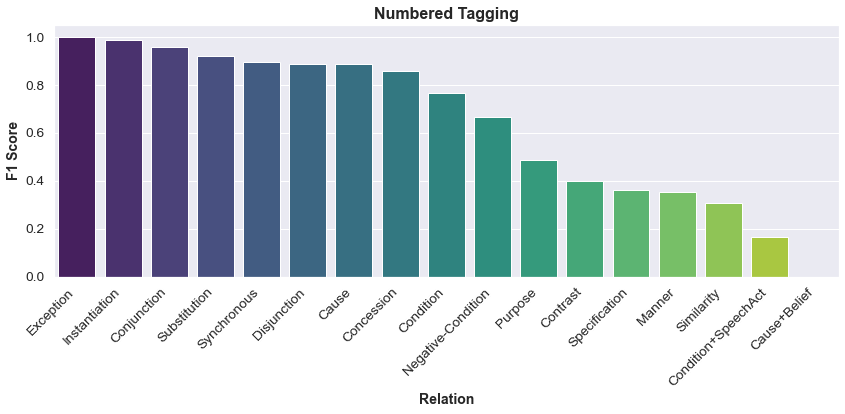

In [222]:

sorted_summary_df_unllama = summary_df_unllama.sort_values(by="F1_score", ascending=False)

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.25)      
sns.barplot(data=sorted_summary_df_unllama, x="Relation", y="F1_score", palette="viridis")
plt.xlabel("Relation", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score", fontsize=14, fontweight='bold')
plt.title("Numbered Tagging", fontsize=16, fontweight='bold')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")  

plt.tight_layout()
plt.show()

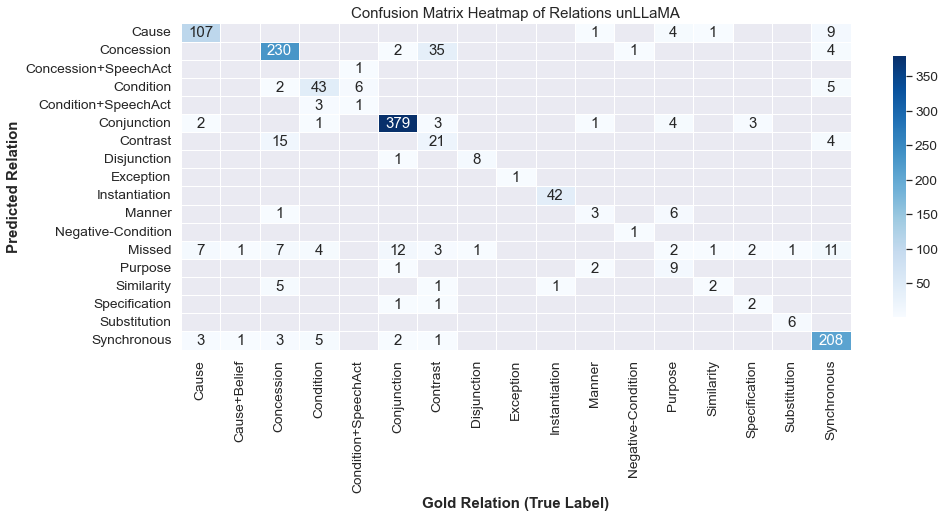

In [221]:
confusion_matrix = pd.crosstab(df_reassessed['Predicted_relation'], df_reassessed['Gold_relation'])
confusion_matrix.rename(index={'O': 'Missed'}, columns={'O': 'Missed'}, inplace=True)
mask = confusion_matrix == 0
plt.figure(figsize=(15, 6))  
sns.set(font_scale=1.25)      

sns.heatmap(
    confusion_matrix, 
    annot=True,              # Display the counts on the heatmap
    cmap="Blues",            # Use a color map 
    fmt='g',                 # 'g' ensures integers are displayed correctly
    linewidths=0.5,          # Add gridlines
    mask=mask,               # mask the 0s
    cbar_kws={'shrink': 0.8} # Shrink the colorbar slightly
)

plt.xlabel('Gold Relation (True Label)',fontweight='bold')
plt.ylabel('Predicted Relation',fontweight='bold')
plt.title('Confusion Matrix of Relations (Numbered Tagging)')
plt.show()

In [203]:
from collections import defaultdict
tp = defaultdict(int)
predicted_count = defaultdict(int)
gold_count = defaultdict(int)

tp_count = 0
# Count true positives, predicted, and gold occurrences
for _, row in df_recall.iterrows():
    pred_rel = row["Sense_predicted"]
    gold_rel = row["Sense"]
    if pred_rel == gold_rel:
        tp[pred_rel] += 1 
        tp_count += 1
    predicted_count[pred_rel] += 1  
    gold_count[gold_rel] += 1  
    

# Calculate precision and recall
precision = {rel: tp[rel] / predicted_count[rel] if predicted_count[rel] > 0 else 0 for rel in set(predicted_count) | set(gold_count)}
recall = {rel: tp[rel] / gold_count[rel] if gold_count[rel] > 0 else 0 for rel in set(predicted_count) | set(gold_count)}

# Calculate F1 scores
f1_scores = {
    rel: (2 * precision[rel] * recall[rel]) / (precision[rel] + recall[rel]) if (precision[rel] + recall[rel]) > 0 else 0
    for rel in set(predicted_count) | set(gold_count)
}

print("Precision per relation:")
for rel, value in precision.items():
    print(f"{rel}: {value:.2f}")

print("\nRecall per relation:")
for rel, value in recall.items():
    print(f"{rel}: {value:.2f}")
    
print("\nF1 Score per relation:")
count = 0 
sum_f1 = 0
for rel, value in f1_scores.items():
    sum_f1 += value
    count += 1
    print(f"{rel}: {value:.2f}")

macrof1 = sum_f1 / count if count > 0 else 0
print(f"\nMacro F1 score = {macrof1:}")

Precision per relation:
Arg2-as-cond: 0.77
Arg1-as-subst: 1.00
Disjunction: 0.89
Arg2-as-denier+SpeechAct: 0.00
Contrast: 0.53
Arg2-as-subst: 1.00
Conjunction: 0.96
Arg2-as-manner: 0.30
Succession: 0.94
Arg2-as-denier: 0.84
Arg1-as-cond: 0.00
Similarity: 0.22
Arg2-as-detail: 0.50
Arg2-as-goal: 0.86
Arg1-as-excpt: 1.00
Arg2-as-instance: 1.00
Arg1-as-denier: 0.60
Arg2-as-negCond: 1.00
Precedence: 0.97
Result: 0.93
O: 0.00
Reason: 0.85
Arg1-as-goal: 0.60
Condition+SpeechAct: 0.25
Synchronous: 0.78
Reason+Belief: 0.00

Recall per relation:
Arg2-as-cond: 0.78
Arg1-as-subst: 1.00
Disjunction: 0.89
Arg2-as-denier+SpeechAct: 0.00
Contrast: 0.32
Arg2-as-subst: 0.67
Conjunction: 0.95
Arg2-as-manner: 0.43
Succession: 0.64
Arg2-as-denier: 0.88
Arg1-as-cond: 0.00
Similarity: 0.50
Arg2-as-detail: 0.29
Arg2-as-goal: 0.40
Arg1-as-excpt: 1.00
Arg2-as-instance: 0.98
Arg1-as-denier: 0.58
Arg2-as-negCond: 0.50
Precedence: 0.87
Result: 0.89
O: 0.00
Reason: 0.90
Arg1-as-goal: 0.30
Condition+SpeechAct: 0.12


In [194]:
recall_sense = df_recall["sense"].sum()/len(df_recall)
recall_sense

0.822593476531424

In [195]:
df_reassessed_sense = df_reassessed["sense"].sum()/len(df_reassessed)
df_reassessed_sense

0.8456642800318218

In [88]:
recall_identifying = df_recall["connective_ident"].sum()/len(df_recall)
recall_identifying

0.958631662688942

In [196]:
df_reassessed_identifying = df_reassessed["connective_ident"].sum()/len(df_reassessed)
df_reassessed_identifying

0.958631662688942

In [ ]:
columns = ['Connective', 'Sense','Sense_predicted', 'Gold_sent', 'Prediction_sent', 'connective_ident', 'sense']
data = []
count = 0
# Create a DataFrame row for each connective and sense (RECALL) iterating over the gold data
for sentence, true_pred, true_label in zip(combined_sentences, true_preds, true_labels):
        for tokens, pred_label, gold_label in zip(sentence, true_pred, true_label):
            for i, token in enumerate(tokens.split()):
                if '<' in token and '_' in token:
                    count += 1 
                    connective = token.replace('<', '').replace('>', '').split('_')[0]
                    sense = token.replace('<', '').replace('>', '').split('_')[1]
                    
                    # Check if gold connective is identified
                    connective_ident = 1 if true_pred[i] != 'O' else 0
                    sense_match = 1 if true_pred[i] == sense else 0
                    # Prepare the data row for the DataFrame
                    data.append([connective, sense, true_pred[i],' '.join(sentence), ' '.join(true_pred), connective_ident, sense_match])

df_recall = pd.DataFrame(data, columns=columns)
df_recall

In [200]:
columns = ['Connective', 'Sense','Sense_predicted', 'Gold_sent', 'Prediction_sent', 'connective_ident', 'sense']
data = []

# Create a DataFrame row for each connective and sense (Precision) iterating over the predicted data
for sentence, true_pred, true_label in zip(combined_sentences, true_preds, true_labels):
        for token, pred_label, gold_label in zip(sentence[0].split(), true_pred, true_label):
                if pred_label != "O":
                    connective = token.replace('<', '').replace('>', '').split('_')[0]
                    sense = gold_label
                    
                    # Check if gold connective is identified
                    connective_ident = 1 if gold_label != 'O' else 0

                    # Check if predicted sense matches gold sense
                    sense_match = 1 if pred_label == gold_label else 0

                    # Prepare the data row for the DataFrame
                    data.append([connective, sense,pred_label , ' '.join(sentence), ' '.join(true_pred), connective_ident, sense_match])
                    
df_precision = pd.DataFrame(data, columns=columns)
df_precision

,Connective,Sense,Sense_predicted,Gold_sent,Prediction_sent,connective_ident,sense
0,But,Arg2-as-denier,Arg2-as-denier,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
1,while,Arg1-as-denier,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,0
2,as,Synchronous,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
3,by,Arg1-as-goal,Arg2-as-manner,Big investment banks refused to step up to the...,O O O O O O O O O O O O O O O O Arg2-as-manner...,1,0
4,and,Conjunction,Conjunction,Seven Big Board stocks UAL AMR BankAmerica Wal...,O O O O O O O O O O O O O O O O O O O Conjunct...,1,1
...,...,...,...,...,...,...,...
1246,while,Synchronous,Synchronous,Himont faces lower prices for its mainstay pro...,O O O O O O O O O Synchronous O O O O O O O O ...,1,1
1247,and,Conjunction,Conjunction,Himont faces lower prices for its mainstay pro...,O O O O O O O O O Synchronous O O O O O O O O ...,1,1
1248,because,Reason,Reason,Some analysts hedge their estimates for Quantu...,O O O O O O O Reason O O O O O O O O O O O,1,1
1249,But,Arg2-as-denier,Arg2-as-denier,<But>_Arg2-as-denier the estimates range from ...,Arg2-as-denier O O O O O O O O O O,1,1


In [201]:
# reassess on level2 for precision
def reassess_labels(row):
    row["Sense"] = sense_level_mapping.get(row["Sense"], row["Sense"])
    row["Sense_predicted"] = sense_level_mapping.get(row["Sense_predicted"], row["Sense_predicted"])
    return row

df_reassessed_precision = df_precision.apply(reassess_labels, axis=1)

df_reassessed_precision[["connective_ident", "sense"]] = df_reassessed.apply(
    lambda row: pd.Series(reassess_ident_sense(row)), axis=1
)


# Display the updated dataframe
df_reassessed_precision

,Connective,Sense,Sense_predicted,Gold_sent,Prediction_sent,connective_ident,sense
0,But,Concession,Concession,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
1,while,Concession,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,0
2,as,Synchronous,Synchronous,<But>_Arg2-as-denier <while>_Arg1-as-denier th...,Arg2-as-denier Synchronous O O O O O O O O O S...,1,1
3,by,Purpose,Manner,Big investment banks refused to step up to the...,O O O O O O O O O O O O O O O O Arg2-as-manner...,1,0
4,and,Conjunction,Conjunction,Seven Big Board stocks UAL AMR BankAmerica Wal...,O O O O O O O O O O O O O O O O O O O Conjunct...,1,1
...,...,...,...,...,...,...,...
1246,while,Synchronous,Synchronous,Himont faces lower prices for its mainstay pro...,O O O O O O O O O Synchronous O O O O O O O O ...,1,1
1247,and,Conjunction,Conjunction,Himont faces lower prices for its mainstay pro...,O O O O O O O O O Synchronous O O O O O O O O ...,1,1
1248,because,Cause,Cause,Some analysts hedge their estimates for Quantu...,O O O O O O O Reason O O O O O O O O O O O,1,1
1249,But,Concession,Concession,<But>_Arg2-as-denier the estimates range from ...,Arg2-as-denier O O O O O O O O O O,1,0


In [98]:
precision = df_precision["sense"].sum() / len(df_precision)
precision

0.8265387689848122

In [202]:
precision_level2 = df_reassessed_precision["sense"].sum() / len(df_reassessed_precision)
precision_level2

0.8465227817745803

In [99]:
precision_identifying = df_precision["connective_ident"].sum()/len(df_precision)
precision_identifying

0.9632294164668266

In [100]:
calculate_f1(precision_identifying, recall_identifying)

0.9609250398724084

## Getting precision and recall per connective 

In [46]:
df_recall['Connective'] = df_recall['Connective'].str.lower()
df_precision['potential_Connective'] = df_precision['potential_Connective'].str.lower()

# Group by the normalized connectives and calculate average for recall
grouped_recall = df_recall.groupby('Connective').agg({'connective_ident': 'mean', 'sense': 'mean'}).reset_index()
grouped_recall.columns = ['Connective', 'Recall-identification', 'Recall-sense']

# Group by the normalized connectives and calculate average for precision
grouped_precision = df_precision.groupby('potential_Connective').agg({'connective_ident': 'mean', 'sense': 'mean'}).reset_index()
grouped_precision.columns = ['Connective', 'Precision-identification', 'Precision-sense']

# Merge recall and precision data
result = pd.merge(grouped_recall, grouped_precision, on='Connective', how='left')

# Select relevant columns
final_result = result[['Connective', 'Precision-identification', 'Recall-identification', 'Precision-sense', 'Recall-sense']]

In [95]:
def calculate_f1(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

In [49]:
final_result['F1-identification'] = final_result.apply(lambda row: calculate_f1(row['Precision-identification'], row['Recall-identification']), axis=1)
final_result['F1-sense'] = final_result.apply(lambda row: calculate_f1(row['Precision-sense'], row['Recall-sense']), axis=1)

yup
yup
yup
yup
yup
yup


/var/folders/ff/32yqt2f51gl_x3n8z960mc2r0000gn/T/ipykernel_28210/3527467244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['F1-identification'] = final_result.apply(lambda row: calculate_f1(row['Precision-identification'], row['Recall-identification']), axis=1)
/var/folders/ff/32yqt2f51gl_x3n8z960mc2r0000gn/T/ipykernel_28210/3527467244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result['F1-sense'] = final_result.apply(lambda row: calculate_f1(row['Precision-sense'], row['Reca

In [884]:
#sanity check
selected_rows = df_precision[df_precision["potential_Connective"] == 'und']
recall_and = (selected_rows["connective_ident"].sum() / len(selected_rows))
recall_and

0.885593220338983

In [1087]:
sorted_final_results = final_result.sort_values(by=['F1-identification',"F1-sense"], ascending=True)
#sorted_final_results[sorted_final_results.isna().any(axis=1)]
sorted_final_results

,Connective,Precision-identification,Recall-identification,Precision-sense,Recall-sense,F1-identification,F1-sense
49,previously,0.500000,0.333333,0.500000,0.333333,0.400000,0.400000
33,later,1.000000,0.333333,1.000000,0.333333,0.500000,0.500000
50,rather,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75,with,0.625000,0.714286,0.500000,0.571429,0.666667,0.533333
43,once,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
...,...,...,...,...,...,...,...
26,hence,NaN,0.000000,NaN,0.000000,NaN,NaN
40,now,NaN,0.000000,NaN,0.000000,NaN,NaN
58,specifically,NaN,0.000000,NaN,0.000000,NaN,NaN
70,well,NaN,0.000000,NaN,0.000000,NaN,NaN


In [1033]:
# Adding a column for the length of strings in column 'A'
df_recall['A_length'] = df_recall['Gold_sent'].apply(len)

# Sorting the DataFrame based on the length of the strings in column 'A'
df_sorted = df_recall.sort_values(by='A_length')

# Dropping the temporary 'A_length' column
df_sorted = df_sorted.drop(columns=['A_length'])
df_sorted.query("connective_ident == 0")

,Connective,Sense,Gold_sent,Prediction_sent,connective_ident,sense
922,so,Result,<So>_Result she thinks the damage will be shor...,O O O O O O O O O O,0,0
1076,previously,Succession,It was <previously>_Succession thought ASKO he...,O O O O O O O O O O O O O O,0,0
560,and,Conjunction,<And>_Conjunction the cableTV operators CNNs d...,O O O O O O O O O O O O O O O O,0,0
350,previously,Succession,The account was <previously>_Succession handle...,O O O O O O O O O O O O O O O,0,0
1230,hence,Result,The Fed of course knows that very well <hence>...,O O O O O O O O O O O O O O O O O O O,0,0
994,and,Conjunction,In academia a socalled Friday the 13th effect ...,O O O O O O O O O O O O O O O O O O,0,0
430,or,Disjunction,Rosie reinvented this man who may <or>_Disjunc...,O O O O O O O O O O O O O O O O O O O O O,0,0
856,but,Contrast,Clearly the question with Chicken Soup is not ...,O O O O O O O O O O O O O O O O O O O O O,0,0
1215,however,Arg1-as-denier,The 1987 crash was a false alarm <however>_Arg...,O O O O O O O O O O O O O O O O O O,0,0
514,later,Precedence,These cleanbank transactions leave the bulk of...,O O O O O O O O O O O O O O O O O O O,0,0
